In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq.job import job_monitor
provider = IBMQ.load_account()

/tmp/ipykernel_191/2779030276.py:10: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


# 回路の生成

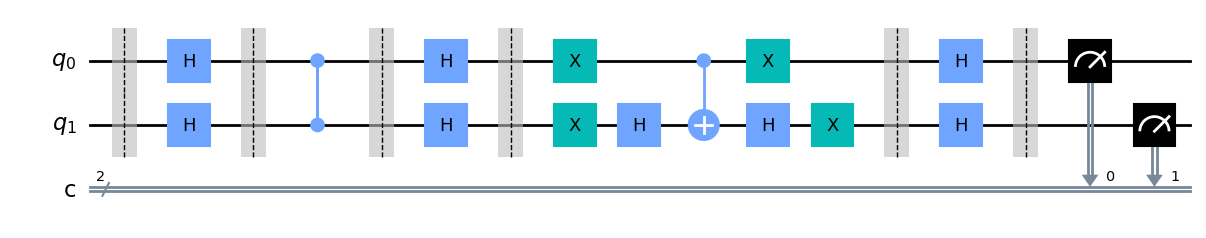

In [4]:
#量子ビット数と古典ビット数
q = 2
c = 2


#全ての古典bitにアダマールをかける回路。オラクル回路と位相回路の間に挟む
circ_h = QuantumCircuit(q, c)
circ_h.barrier()
for i in range(0,q):
    circ_h.h(i)


#オラクル回路
circ_o = QuantumCircuit(q, c)
circ_o.barrier()

#解が1
#circ_o.x(1)
#circ_o.h(1)
#circ_o.cx(0,1)
#circ_o.h(1)
#circ_o.x(1)


#解が3
circ_o.cz(0,1)


#位相回路
circ_p = QuantumCircuit(q, c)
circ_p.barrier()
circ_p.x(0)
circ_p.x(1)
circ_p.h(1)
circ_p.cx(0,1)
circ_p.h(1)
circ_p.x(1)
circ_p.x(0)

#グローバーの繰り返し回路
circ_g = circ_o.compose(circ_h).compose(circ_p).compose(circ_h)

#測定
meas = QuantumCircuit(q, c)
meas.barrier()
meas.measure([0,1],[0,1])


#回路をn回繰り返す関数
def repeat_circuit(n):
    circ = circ_h
    for i in range(0,n):
        circ = circ.compose(circ_g)
    circ = circ.compose(meas)
    return circ


#回路を表示
repeat_circuit(1).draw(output='mpl')

# シミュレータでの実行
表示形式は、[00, 01, 10, 11]の各確率の配列を繰り返し回数ごとにprintする形にしました。

In [6]:
#シミュレータで試す
simulator = Aer.get_backend('qasm_simulator')

#回路の最大繰り返し回数
n = 5

#ショット数、結果の格納庫を用意
shots = 2048
results_sim = []

#回路をシミュレート、測定結果を取得して配列に
for i in range(1,n+1):
    job_sim = execute(repeat_circuit(i), backend=simulator, shots=shots)
    results_sim.append(job_sim.result().get_counts(repeat_circuit(i)))


#結果から確率を計算し、配列にして表示
for i, counts in enumerate(results_sim):
    a0 = list(counts.values())
    ntotal = sum(a0)
    p00 = counts.get('00', 0) / ntotal
    p01 = counts.get('01', 0) / ntotal
    p10 = counts.get('10', 0) / ntotal
    p11 = counts.get('11', 0) / ntotal
    a = [p00, p01, p10, p11]
    print(f"{i+1}回繰り返した場合: {a}")



1回繰り返した場合: [0.0, 0.0, 0.0, 1.0]
2回繰り返した場合: [0.2470703125, 0.2333984375, 0.2626953125, 0.2568359375]
3回繰り返した場合: [0.22998046875, 0.25439453125, 0.25341796875, 0.26220703125]
4回繰り返した場合: [0.0, 0.0, 0.0, 1.0]
5回繰り返した場合: [0.25927734375, 0.2548828125, 0.2412109375, 0.24462890625]


繰り返し回数の式の通り、n = 1 と n = 4 で確率が1になる。

# 実機での実行

In [19]:
#プロバイダーの設定
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(instance='ibm-q-utokyo/internal/adv-sci-1a-2023s')

back=provider.backends()

for i in back:
    print(i)

<IBMBackend('ibm_perth')>
<IBMBackend('ibm_sherbrooke')>
<IBMBackend('ibmq_belem')>
<IBMBackend('ibmq_lima')>
<IBMBackend('ibmq_manila')>
<IBMBackend('simulator_statevector')>
<IBMBackend('ibm_auckland')>
<IBMBackend('ibm_kawasaki')>
<IBMBackend('ibm_lagos')>
<IBMBackend('ibmq_guadalupe')>
<IBMBackend('ibmq_jakarta')>
<IBMBackend('ibmq_mumbai')>
<IBMBackend('ibmq_qasm_simulator')>
<IBMBackend('simulator_extended_stabilizer')>
<IBMBackend('ibm_algiers')>
<IBMBackend('ibm_nazca')>
<IBMBackend('ibm_nairobi')>
<IBMBackend('ibmq_quito')>
<IBMBackend('ibm_brisbane')>
<IBMBackend('ibm_cairo')>
<IBMBackend('ibm_hanoi')>
<IBMBackend('ibmq_kolkata')>
<IBMBackend('simulator_mps')>
<IBMBackend('simulator_stabilizer')>


In [20]:
#デバイスを取得
device=back[7]

#回路の最大繰り返し回数
n = 5

#ショット数、結果の格納庫を用意
shots = 2048
results_exp = []

#回路を実行、測定結果を取得して配列に
for i in range(1,n+1):
    job_exp = execute(repeat_circuit(i), backend = device, shots=shots)
    results_exp.append(job_exp.result().get_counts(repeat_circuit(i)))

In [21]:
#各状態の確率を格納する配列を用意
probability_exp = []

#結果から確率を計算し、配列に
for counts in results_exp:
    a0 = list(counts.values())
    ntotal = sum(a0)
    p00 = counts.get('00', 0) / ntotal
    p01 = counts.get('01', 0) / ntotal
    p10 = counts.get('10', 0) / ntotal
    p11 = counts.get('11', 0) / ntotal
    a = [p00, p01, p10, p11]
    probability_exp.append(a)

# 表示
print(probability_exp)

[[0.017578125, 0.958984375, 0.0029296875, 0.0205078125], [0.22412109375, 0.28564453125, 0.248046875, 0.2421875], [0.28955078125, 0.228515625, 0.23583984375, 0.24609375], [0.02490234375, 0.9345703125, 0.01171875, 0.02880859375], [0.19580078125, 0.30908203125, 0.24755859375, 0.24755859375]]


シミュレータと違い、ノイズが発生している。繰り返し回数が多いn=4ではノイズが大きくなっているのが分かる。